In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/idc-410-spring-2023/train_labels.npy
/kaggle/input/idc-410-spring-2023/sample_submission.csv
/kaggle/input/idc-410-spring-2023/test_data.npy
/kaggle/input/idc-410-spring-2023/dev_data.npy
/kaggle/input/idc-410-spring-2023/dev_labels.npy
/kaggle/input/idc-410-spring-2023/train_data.npy


In [20]:
import numpy as np
from sklearn.utils import shuffle
import tensorflow.keras as ke
import matplotlib.pyplot as plt

In [16]:
X_Dev = np.load("/kaggle/input/idc-410-spring-2023/train_data.npy",allow_pickle=True,encoding="bytes")
Y_Dev = np.load("/kaggle/input/idc-410-spring-2023/train_labels.npy",allow_pickle=True,encoding="bytes")  

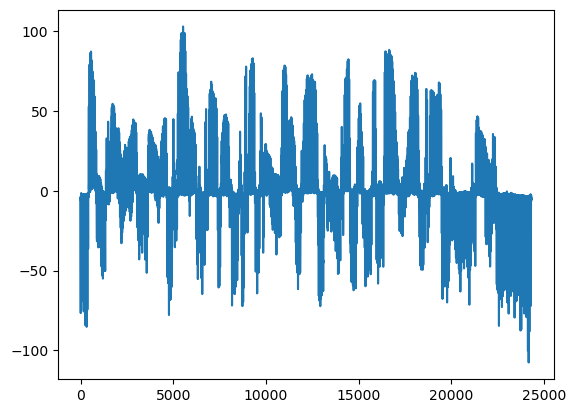

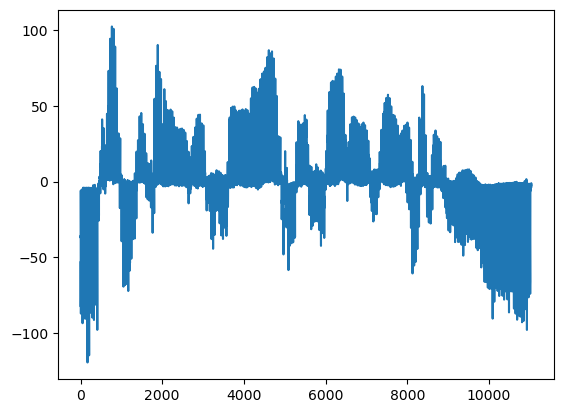

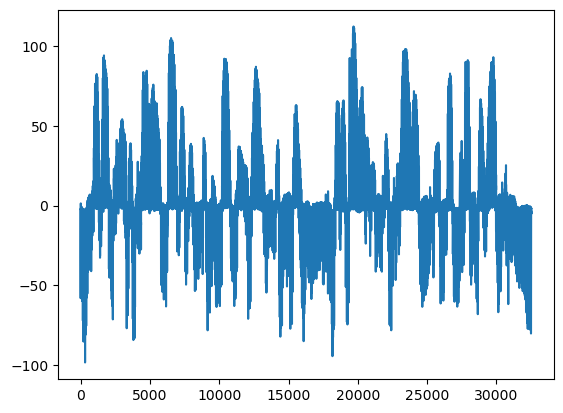

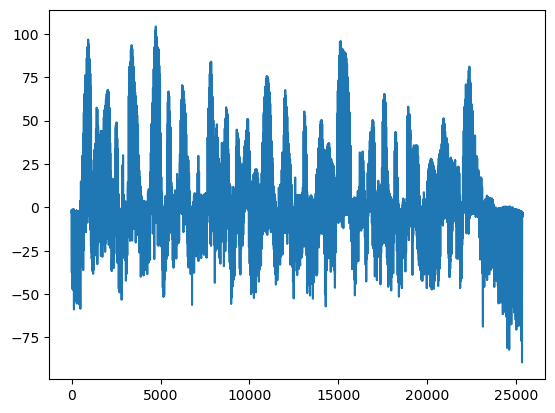

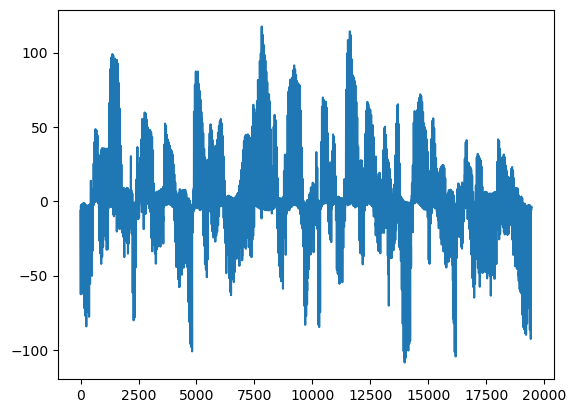

In [49]:
for i in X_Dev[:5]:
    sound = np.array([])
    for j in i[0]:
        sound = np.append(sound, j)
    plt.plot(sound)
    plt.show()

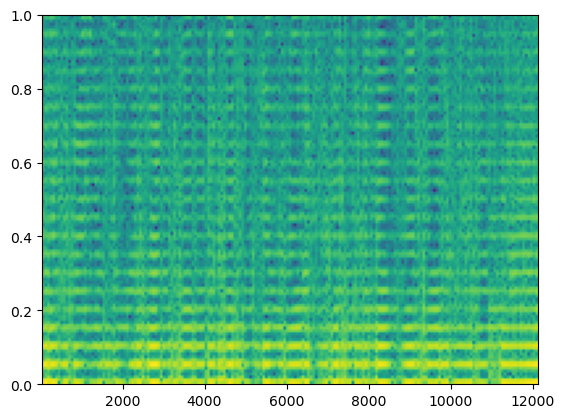

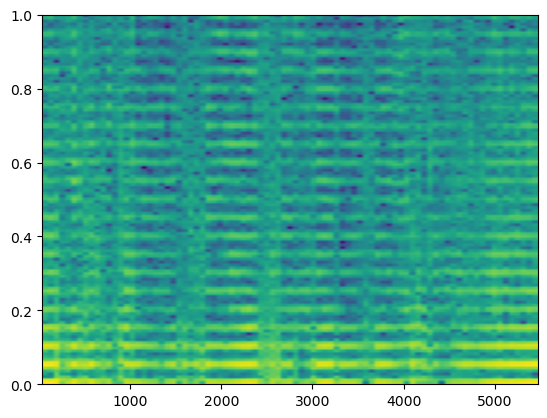

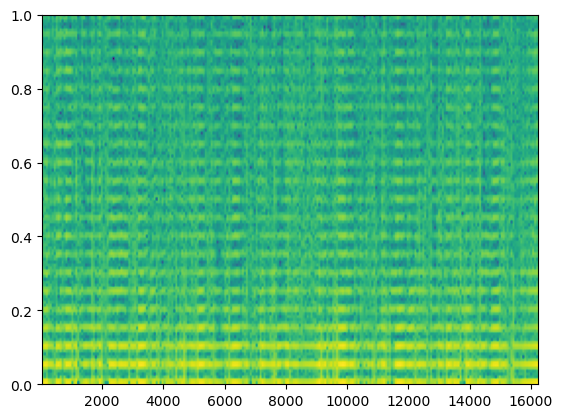

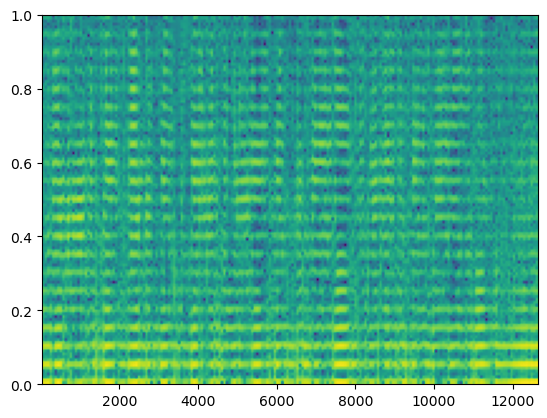

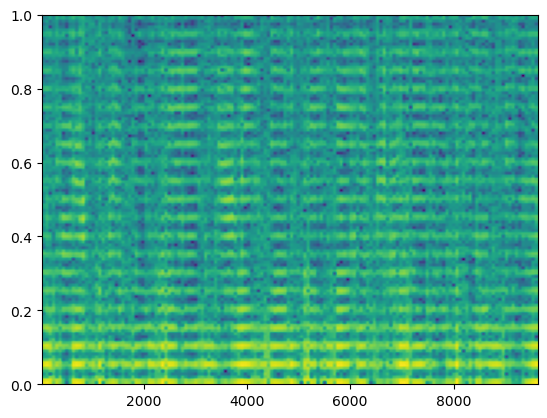

In [48]:
for i in X_Dev[:5]:
    sound = np.array([])
    for j in i[0]:
        sound = np.append(sound, j)
    plt.specgram(sound)
    plt.show()

In [5]:
def extract_frames_from_bounds(utterance, bounds):
    lengths = np.diff(np.concatenate(( bounds, [len(utterance)])))
    return [utterance[start:start+length] for start, length in zip(bounds, lengths)]

def extract_phoneme_wise_data(data):
    return np.concatenate(list(map(extract_frames_from_bounds, data[:, 0], data[:, 1])))

def extract_labels(labels):
    return np.concatenate(labels)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, input_size=(None, 40, 1)):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.input_size = input_size
        self.n = len(self.X)

    def __getitem__(self, index):
        X_batch = tf.keras.utils.pad_sequences(self.X[index * self.batch_size:(index + 1) * self.batch_size])
        y_batch = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return X_batch, y_batch
    
    def __len__(self):
        return self.n // self.batch_size

In [6]:
X = extract_phoneme_wise_data(X_Dev)
y = extract_labels(Y_Dev)

del X_Dev
del Y_Dev

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
train_datagen = DataGenerator(X, y, batch_size = 128)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape
input_shape = (None, 40)  # Variable length sequences of 40-dimensional vectors

# Define the input layer
inputs = layers.Input(shape=input_shape)

# Add the convolutional layers
x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Add the recurrent layers
x = layers.LSTM(units=128, return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.LSTM(units=128)(x)
x = layers.BatchNormalization()(x)

# Add the output layer
x = layers.Dense(units=128, activation='relu')(x)
outputs = layers.Dense(units=48, activation='relu')(x)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 40)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          7744      
                                                                 
 batch_normalization_4 (Batc  (None, None, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, 64)          0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         2470

In [52]:
history = model.fit(train_datagen, epochs=10)

Epoch 1/10
9411/9411 [==============================] - 118s 12ms/step - loss: 1.4688 - accuracy: 0.5934
Epoch 2/10
9411/9411 [==============================] - 111s 12ms/step - loss: 1.2815 - accuracy: 0.6404
Epoch 3/10
9411/9411 [==============================] - 110s 12ms/step - loss: 1.2198 - accuracy: 0.6562
Epoch 4/10
9411/9411 [==============================] - 110s 12ms/step - loss: 1.1804 - accuracy: 0.6661
Epoch 5/10
9411/9411 [==============================] - 109s 12ms/step - loss: 1.1510 - accuracy: 0.6743
Epoch 6/10
9411/9411 [==============================] - 110s 12ms/step - loss: 1.1277 - accuracy: 0.6800
Epoch 7/10
9411/9411 [==============================] - 109s 12ms/step - loss: 1.1090 - accuracy: 0.6853
Epoch 8/10
9411/9411 [==============================] - 109s 12ms/step - loss: 1.0932 - accuracy: 0.6894
Epoch 9/10
9411/9411 [==============================] - 109s 12ms/step - loss: 1.0788 - accuracy: 0.6928
Epoch 10/10
9411/9411 [==============================] 

In [10]:
class TestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, batch_size, input_size=(None, 40, 1)):
        self.X = X
#         self.y = y
        self.batch_size = batch_size
        self.input_size = input_size
        self.n = len(self.X)

    def __getitem__(self, index):
        X_batch = tf.keras.utils.pad_sequences(self.X[index * self.batch_size:(index + 1) * self.batch_size])
#         y_batch = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return X_batch
    
    def __len__(self):
        return self.n // self.batch_size

In [11]:
test_data = np.load("/kaggle/input/idc-410-spring-2023/test_data.npy", allow_pickle=True)
testX = extract_phoneme_wise_data(test_data)

del test_data
testdatagen = TestDataGenerator(testX, batch_size = 263)

In [12]:
predictions = np.argmax(model.predict(testdatagen), axis=1)

2171/2171 [==============================] - 19s 8ms/step


In [14]:
submission = pd.DataFrame({'id' : np.arange(0, len(testX)), 'label' : predictions})
submission.to_csv("submission.csv", index=False)

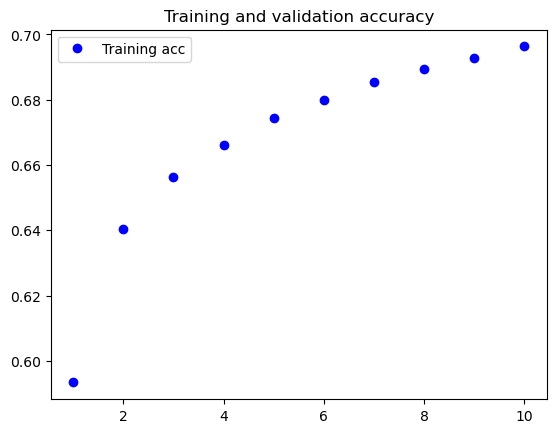

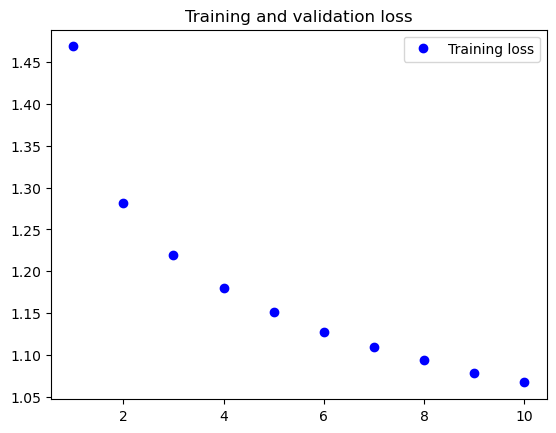

In [55]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()